In [1]:
import torch
import os
import PlotModule
import matplotlib.pyplot as plt
from Model.PyTorch_CIFAR10.cifar10_models.resnet import resnet18

model_vanilla = resnet18(pretrained=True)

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FineTuning/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

## conductance distribution

Min Nonzero Gp (FC): 0.011895670555531979, Min Nonzero Gm (FC): 0.014217847026884556
Min Nonzero Gp (Conv): 1.1238326180773583e-07, Min Nonzero Gm (Conv): 9.361220776327173e-08


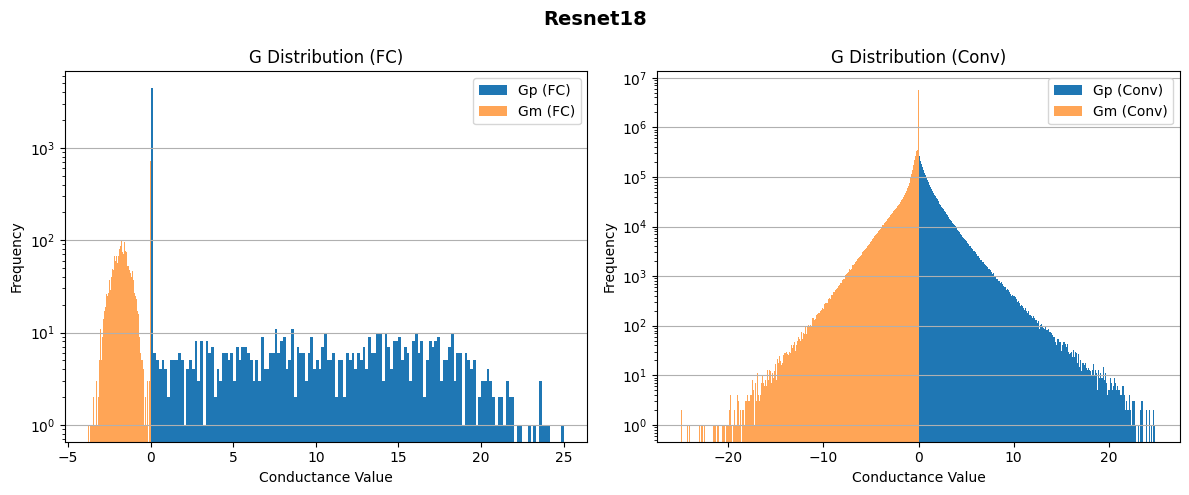

In [2]:
model_vanilla = resnet18(pretrained=True)
PlotModule.plot_conductance_distribution(model_vanilla, 'Resnet18', True, True)

Min Nonzero Gp (FC): 2.2370553016662598, Min Nonzero Gm (FC): 2.2239603996276855
Min Nonzero Gp (Conv): 0.44036930799484253, Min Nonzero Gm (Conv): 0.44036737084388733


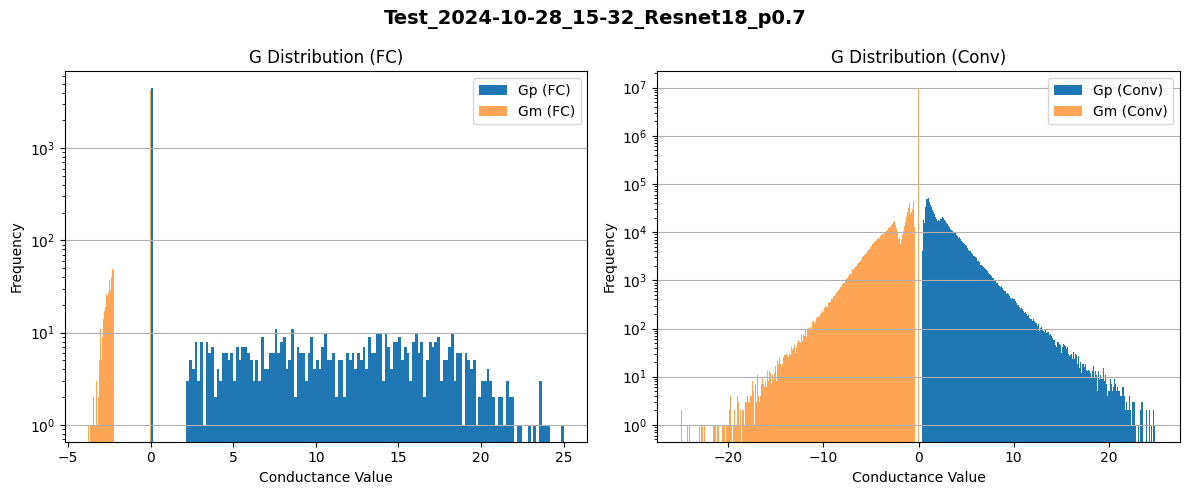

In [4]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

PlotModule.plot_conductance_distribution(pruned_model, folder_name, True, True)

Min Nonzero Gp (FC): 0.0012116378638893366, Min Nonzero Gm (FC): 2.826629497576505e-06
Min Nonzero Gp (Conv): 2.1019476964872256e-42, Min Nonzero Gm (Conv): 4.414090162623174e-42


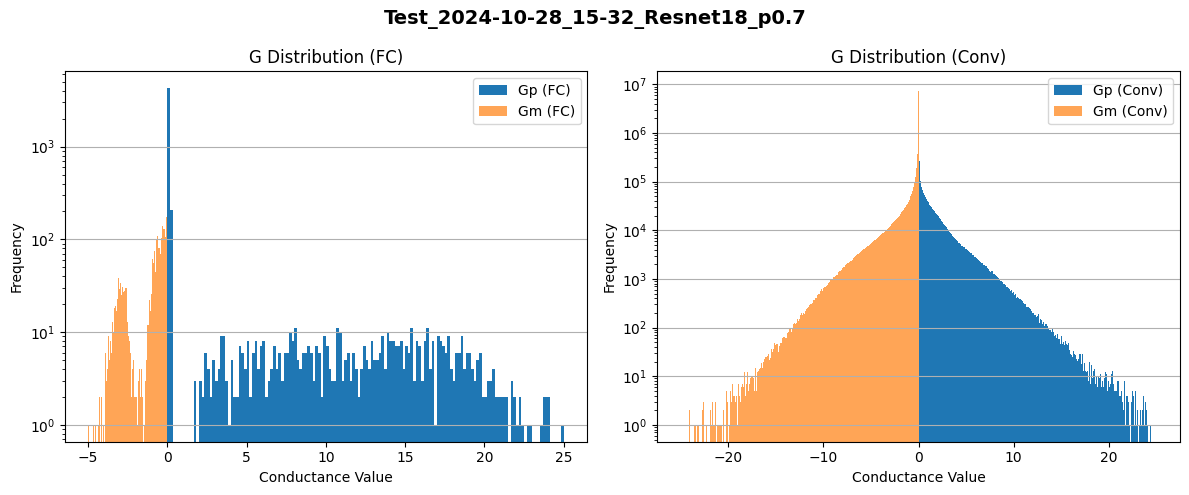

In [2]:
PlotModule.plot_conductance_distribution(finetuned_model, folder_name, True, True)

## 특정 module만 그리기

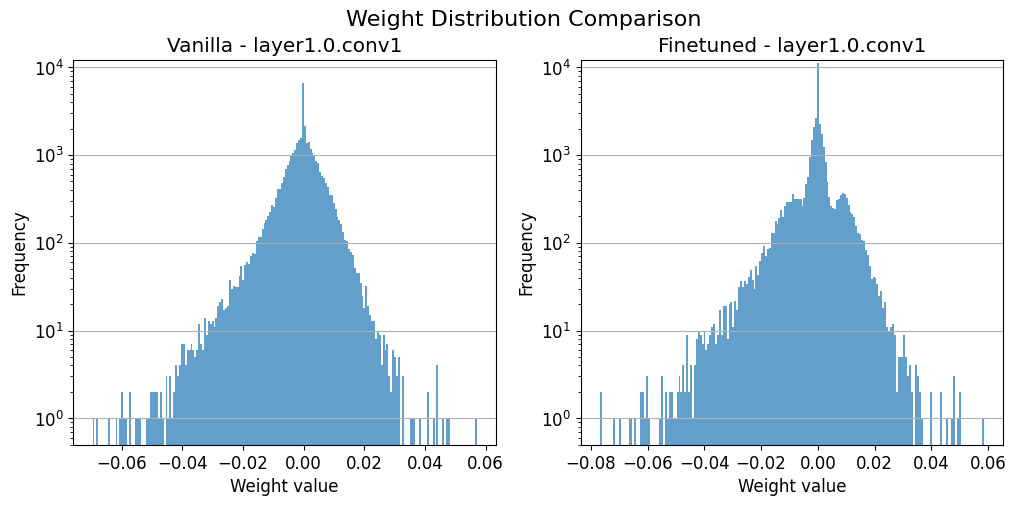

In [36]:
plot_weight_comparison(model_vanilla, finetuned_model, 'layer1.0.conv1')

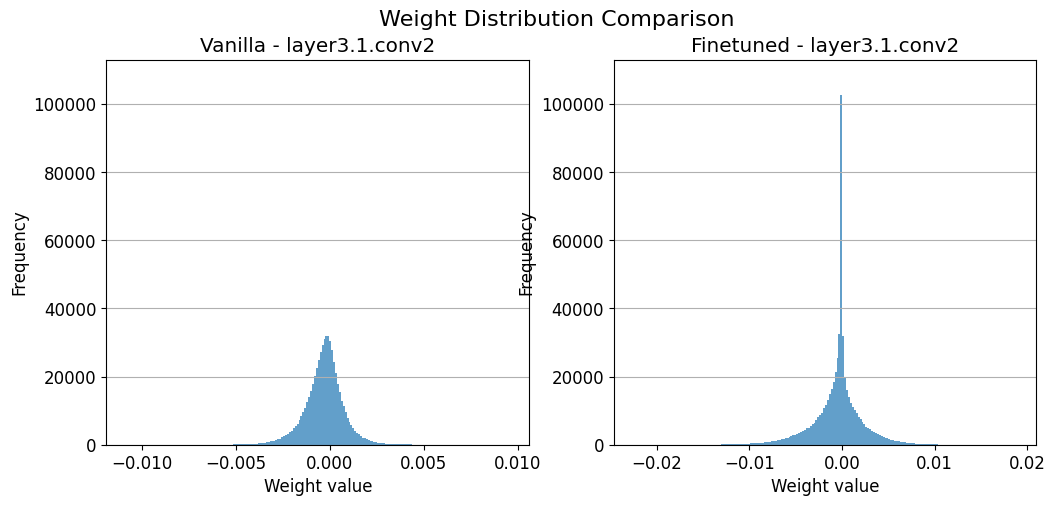

In [46]:
plot_weight_comparison(model_vanilla, finetuned_model, 'layer3.1.conv2')

## weight 저장

In [40]:
import scipy
def save_weights_for_matlab(model, layer_name, filename="weights.mat"):
    """Extracts weights from a specific layer and saves them in a .mat file for MATLAB."""
    weights = None
    for name, param in model.named_parameters():
        if layer_name in name:
            weights = param.data.cpu().numpy().flatten()  # 1D 배열로 변환
            break
    
    if weights is not None:
        scipy.io.savemat(filename, {"weights": weights})
        print(f"Saved weights to {filename}")
    else:
        print("Layer not found!")

In [47]:
save_weights_for_matlab(model_vanilla, "layer3.1.conv2.weight", "3.1.2.vanilla_weights.mat")
save_weights_for_matlab(pruned_model, "layer3.1.conv2.weight", "3.1.2.pruned_weights.mat")
save_weights_for_matlab(finetuned_model, "layer3.1.conv2.weight", "3.1.2.finetuned_weights.mat")

Saved weights to 3.1.2.vanilla_weights.mat
Saved weights to 3.1.2.pruned_weights.mat
Saved weights to 3.1.2.finetuned_weights.mat


## aihwkit G change 함수

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

def compute_total_drift_error(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    """
    전체 모델 weight를 analog로 변환하고,
    드리프트를 적용한 후 초기 conductance와의 차이를 계산합니다.
    """
    inf_model = InfModel(model, dataset, noise_list=[0,0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    total_drift_error = 0.0

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            # Conductance 변환
            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            # Programming noise (optional, realistic)
            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)
            # gp_prog = gp
            # gm_prog = gm

            # Drift coefficient 생성
            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            # Drift 적용
            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)


            # ΔG 계산
            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            drift_error = torch.sum(torch.abs(g_init - g_drifted)).item()
            total_drift_error += drift_error

    return total_drift_error


In [41]:
t_seconds = 9.33e7
drift_error = compute_total_drift_error(finetuned_model, dataset="cifar10", t_seconds=t_seconds)
print(f"Total drift error after {t_seconds}sec: {drift_error:.4f}")

Total drift error after 93300000.0sec: 5586142.4597


In [42]:
drift_error = compute_total_drift_error(model_vanilla, dataset="cifar10", t_seconds=t_seconds)
print(f"Total drift error after {t_seconds}sec: {drift_error:.4f}")

Total drift error after 93300000.0sec: 7553345.4668


In [43]:
drift_error = compute_total_drift_error(pruned_model, dataset="cifar10", t_seconds=t_seconds)
print(f"Total drift error after {t_seconds}sec: {drift_error:.4f}")

Total drift error after 93300000.0sec: 4647739.5808


In [64]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FineTuning/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
tuning_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

drift_error = compute_total_drift_error(tuning_model, dataset="cifar10", t_seconds=t_seconds)
print(f"Total drift error after {t_seconds}sec: {drift_error:.4f}")

Total drift error after 93300000.0sec: 5585996.5508


In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def compute_and_plot_layerwise_drift(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    inf_model = InfModel(model, dataset, noise_list=[0, 0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    layerwise_delta_g = {}
    stats = []

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)

            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)

            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            delta_g = torch.abs(g_init - g_drifted).flatten().numpy()

            layerwise_delta_g[name] = delta_g
            stats.append((name, delta_g.mean(), delta_g.std()))

    # ==== 출력: 통계 요약 ====
    print(f"{'Layer':<40} | {'ΔG Mean':>10} | {'ΔG Std':>10}")
    print("-"*65)
    for name, mean, std in stats:
        print(f"{name:<40} | {mean:10.5f} | {std:10.5f}")

    # ==== 시각화: 레이어별 ΔG 분포 ====
    num_layers = len(layerwise_delta_g)
    cols = 2
    rows = (num_layers + 1) // cols

    plt.figure(figsize=(cols * 6, rows * 4))
    for i, (name, delta_g) in enumerate(layerwise_delta_g.items()):
        plt.subplot(rows, cols, i + 1)
        plt.hist(delta_g, bins=150, color='tomato', alpha=0.8)
        plt.title(f"ΔG Distribution\n{name}")
        plt.xlabel("|ΔG|")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


Layer                                    |    ΔG Mean |     ΔG Std
-----------------------------------------------------------------
conv1.analog_module.shared_weights       |    0.18739 |    0.30460
layer1.0.conv1.analog_module.shared_weights |    0.10028 |    0.17641
layer1.0.conv2.analog_module.shared_weights |    0.14463 |    0.23797
layer1.1.conv1.analog_module.shared_weights |    0.13551 |    0.22477
layer1.1.conv2.analog_module.shared_weights |    0.12512 |    0.20805
layer2.0.conv1.analog_module.shared_weights |    0.14732 |    0.24062
layer2.0.conv2.analog_module.shared_weights |    0.13651 |    0.22394
layer2.0.downsample.0.analog_module.shared_weights |    0.12342 |    0.20604
layer2.1.conv1.analog_module.shared_weights |    0.14882 |    0.24291
layer2.1.conv2.analog_module.shared_weights |    0.11965 |    0.19939
layer3.0.conv1.analog_module.shared_weights |    0.10137 |    0.17097
layer3.0.conv2.analog_module.shared_weights |    0.10387 |    0.17570
layer3.0.downsample.0.a

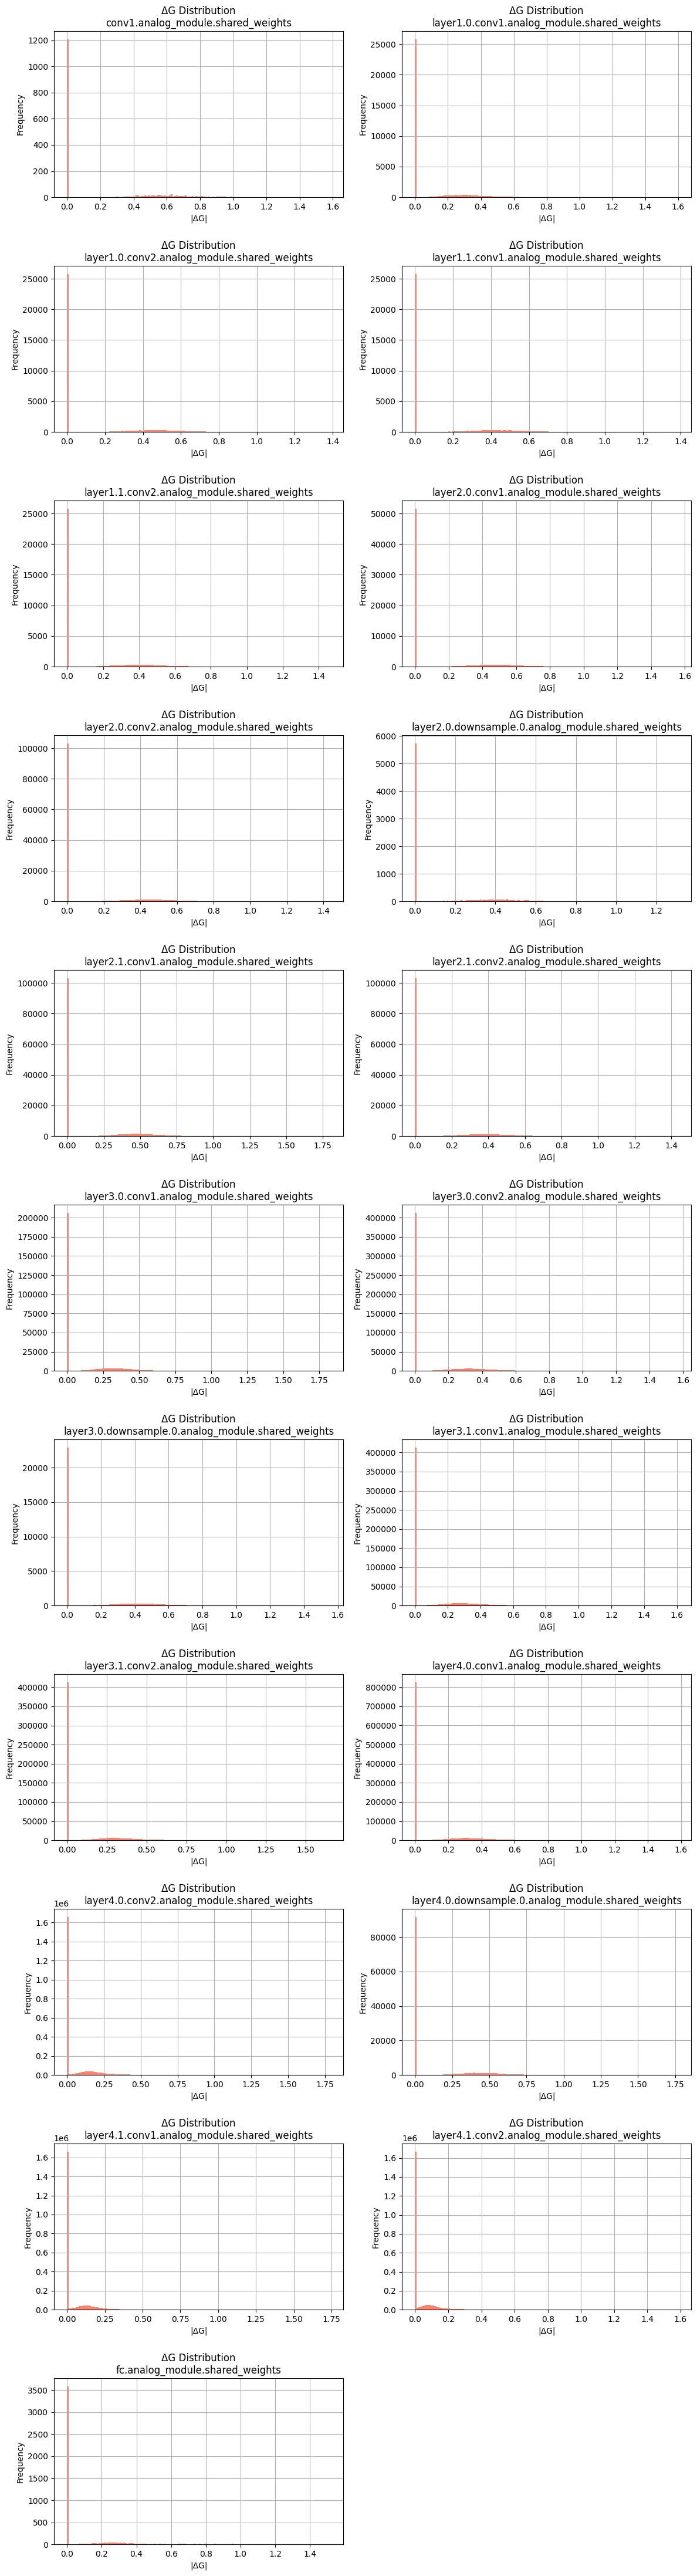

In [38]:
compute_and_plot_layerwise_drift(pruned_model, dataset="cifar10", t_seconds=100)


## finetuned model G 변환 문제 해결

In [2]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'FineTuning/best_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}')

In [55]:
for name, param in finetuned_model.named_parameters():
    if "weight" in name and len(param.size()) > 1: 
        print(name)

conv1.weight
layer1.0.conv1.weight
layer1.0.conv2.weight
layer1.1.conv1.weight
layer1.1.conv2.weight
layer2.0.conv1.weight
layer2.0.conv2.weight
layer2.0.downsample.0.weight
layer2.1.conv1.weight
layer2.1.conv2.weight
layer3.0.conv1.weight
layer3.0.conv2.weight
layer3.0.downsample.0.weight
layer3.1.conv1.weight
layer3.1.conv2.weight
layer4.0.conv1.weight
layer4.0.conv2.weight
layer4.0.downsample.0.weight
layer4.1.conv1.weight
layer4.1.conv2.weight
fc.weight


In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

def convert_weights_to_conductance(model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    min_gp_fc, min_gm_fc = None, None
    min_gp_conv, min_gm_conv = None, None

    for name, param in model.named_parameters():
        # print(f"[DEBUG] {name}: max={param.data.max()}, mean={param.data.mean()}")
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()
            
            # print(f"[DEBUG] Weight stats: max={weights.max()}, min={weights.min()}, mean={weights.mean()}")
            
            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            # print(f"[DEBUG] Converted to Conductance: {conductance_pair[0][0].shape}")  # shape of Gp
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환
            # print(f"[DEBUG] Gp nonzero: {torch.count_nonzero(gp)}, Gm nonzero: {torch.count_nonzero(gm)}")

            # 0이 아닌 값들만 필터링
            gp_nonzero = gp[gp > 0]  # 0보다 큰 값만 선택
            gm_nonzero = gm[gm > 0]  # 0보다 큰 값만 선택

            if "fc" in name or weights.shape[0] <= 10:  # Fully Connected Layer
                conductance_list_fc.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_fc = gp_nonzero.min().item() if min_gp_fc is None else min(min_gp_fc, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_fc = gm_nonzero.min().item() if min_gm_fc is None else min(min_gm_fc, gm_nonzero.min().item())

            else:  # Convolutional Layer
                conductance_list_conv.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_conv = gp_nonzero.min().item() if min_gp_conv is None else min(min_gp_conv, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_conv = gm_nonzero.min().item() if min_gm_conv is None else min(min_gm_conv, gm_nonzero.min().item())

    print(f"Min Nonzero Gp (FC): {min_gp_fc}, Min Nonzero Gm (FC): {min_gm_fc}")
    print(f"Min Nonzero Gp (Conv): {min_gp_conv}, Min Nonzero Gm (Conv): {min_gm_conv}")

    return conductance_list_fc, conductance_list_conv

# Conductance distribution plot
def plot_conductance_distribution(model, model_name, gdc:bool, ideal_io:bool):
    inf_model = InfModel(model, "cifar10")
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    conductance_list_fc, conductance_list_conv = convert_weights_to_conductance(analog_model, rpu_config)

    gp_fc_all = np.concatenate([gp for gp, _ in conductance_list_fc]) if conductance_list_fc else np.array([])
    gm_fc_all = np.concatenate([gm for _, gm in conductance_list_fc]) if conductance_list_fc else np.array([])
    
    gp_conv_all = np.concatenate([gp for gp, _ in conductance_list_conv]) if conductance_list_conv else np.array([])
    gm_conv_all = np.concatenate([gm for _, gm in conductance_list_conv]) if conductance_list_conv else np.array([])
    print(f"[DEBUG] gp_fc_all size: {gp_fc_all.size}, gp_conv_all size: {gp_conv_all.size}")

    fig, axes = plt.subplots(1,2, figsize=(12, 5))
    # 전체 제목 (중앙)
    fig.suptitle(model_name, fontsize=14, fontweight='bold')  

    # FC 레이어 Conductance Plot
    axes[0].hist(gp_fc_all, bins=150, alpha=1, label="Gp (FC)")
    axes[0].hist(-gm_fc_all, bins=150, alpha=0.7, label="Gm (FC)")
    axes[0].set_title('G Distribution (FC)')
    axes[0].set_xlabel('Conductance Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, axis='y')
    axes[0].set_yscale('log')

    # Conv 레이어 Conductance Plot
    axes[1].hist(gp_conv_all, bins=500, alpha=1, label="Gp (Conv)")
    axes[1].hist(-gm_conv_all, bins=500, alpha=0.7, label="Gm (Conv)")
    axes[1].set_title('G Distribution (Conv)')
    axes[1].set_xlabel('Conductance Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, axis='y')
    axes[1].set_yscale('log')
    # axes[1].set_xlim(-0.1,10)

    plt.tight_layout()
    plt.show()

Min Nonzero Gp (FC): 0.0012116378638893366, Min Nonzero Gm (FC): 2.826629497576505e-06
Min Nonzero Gp (Conv): 2.1019476964872256e-42, Min Nonzero Gm (Conv): 4.414090162623174e-42
[DEBUG] gp_fc_all size: 5120, gp_conv_all size: 11159232


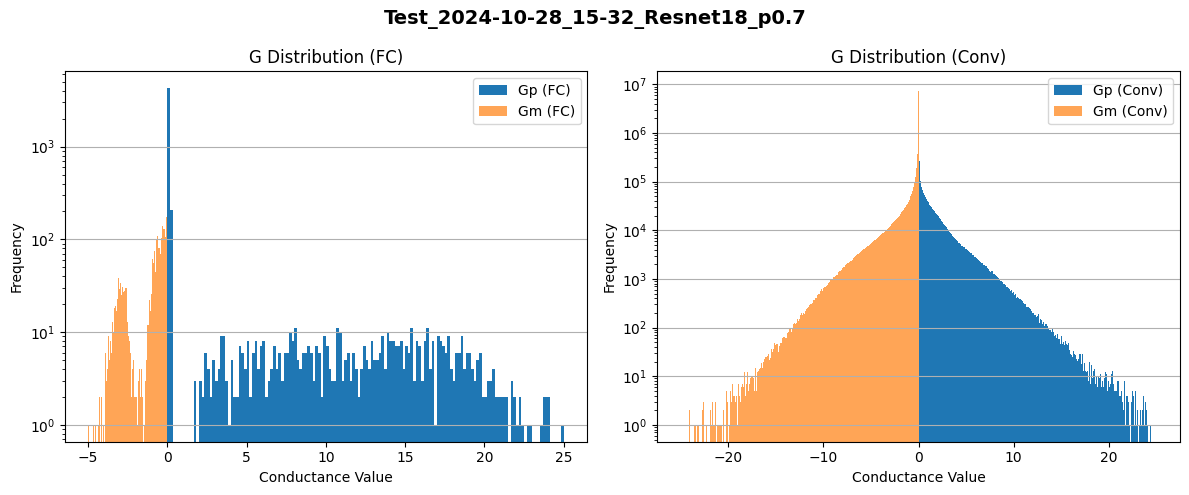

In [15]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'FineTuning/best_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

plot_conductance_distribution(finetuned_model, folder_name, True, True)